# Setting up the Environment

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dropout, Activation, Dense, BatchNormalization, MaxPooling2D, Flatten, GlobalAveragePooling2D

In [2]:
tf.__version__

'2.0.0-beta1'

In [3]:
tf.test.is_gpu_available()

True

# Getting the Data

**The 0-9 indices correspond to the following labels:- <br />
0 -> T-shirt/top <br />
1 -> Trouser <br />
2 -> Pullover <br />
3 -> Dress <br />
4 -> Coat <br />
5 -> Sandal <br />
6 -> Shirt <br />
7 -> Sneaker <br />
8 -> Bag <br />
9 -> Ankle boot**

In [4]:
data = pd.read_csv("fashion-mnist_train.csv")
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data.shape

(60000, 785)

In [6]:
X = data.iloc[:,1:]
y = data[['label']]

# Splitting the Data into Train and Validation

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.15, random_state = 42, shuffle = True)

In [8]:
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_valid : ", X_valid.shape)
print("y_valid : ", y_valid.shape)

X_train :  (51000, 784)
y_train :  (51000, 1)
X_valid :  (9000, 784)
y_valid :  (9000, 1)


# Reshaping the Train and Validation Data

**The Images have 784 pixels, that is, 28x28 pixels and 1 channel(greyscale).**

In [9]:
X_train = X_train.to_numpy().reshape(-1, 28, 28, 1)  
y_train = y_train.to_numpy()

In [10]:
X_valid = X_valid.to_numpy().reshape(-1, 28, 28, 1)
y_valid = y_valid.to_numpy()

In [11]:
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_valid : ", X_valid.shape)
print("y_valid : ", y_valid.shape)

X_train :  (51000, 28, 28, 1)
y_train :  (51000, 1)
X_valid :  (9000, 28, 28, 1)
y_valid :  (9000, 1)


In [12]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [13]:
np.unique(y_valid)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

# Displaying 10 random examples

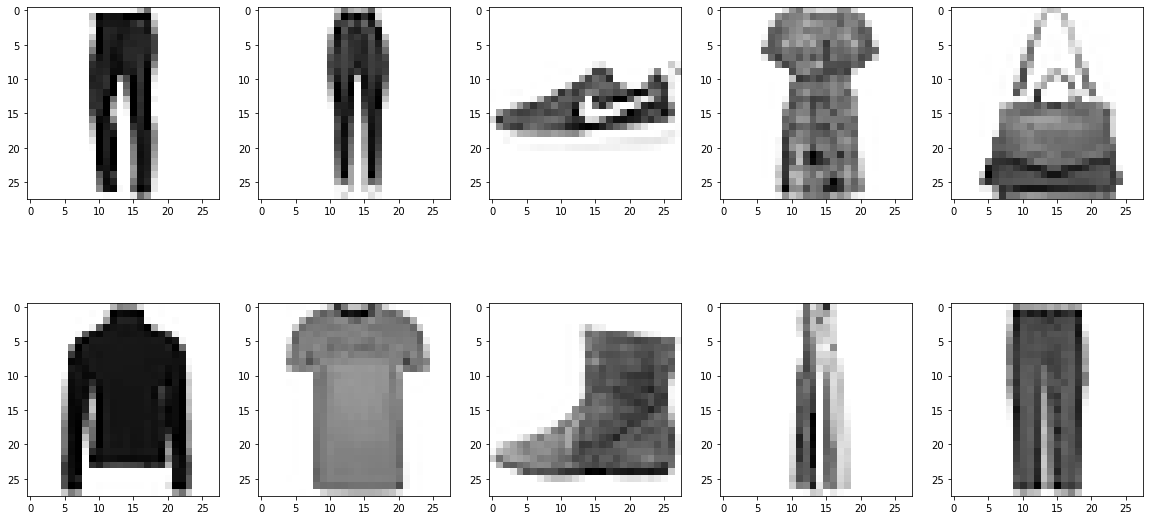

In [14]:
fig = plt.figure(figsize = (20,10))
for j,i in enumerate(range(0,10)):
    plt.subplot(2,5,j+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap = 'Greys')    
plt.show()

# Creating the Convolutional Neural Network

In [15]:
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, padding = 'same', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
          
model.add(Conv2D(128, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(128, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(10, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

**I have used Global Average Pooling instead of Fully Connected Layers at the end to tackle overfitting.**

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       36992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0

# Creating the Train and Test Image Generators

In [17]:
train_datagen = ImageDataGenerator(rotation_range = 5,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   rescale = (1./255)) 

valid_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
train_generator = train_datagen.flow(X_train, y_train, batch_size = 1024, shuffle = True)
validation_generator = valid_datagen.flow(X_valid, y_valid, batch_size = 1024, shuffle = True)

# Compiling and Fitting the Model

In [19]:
checkpoint = ModelCheckpoint('model.h5', monitor = 'val_accuracy', verbose = 0, save_best_only = True, save_weights_only = False, mode = 'max', period = 1)

W0913 10:58:03.906973  6020 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [20]:
optim = tf.keras.optimizers.Adam(lr = 0.0001)
model.compile(optimizer = optim, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [21]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch = len(train_generator),
                           epochs = 500,
                           callbacks = [checkpoint],
                           validation_data = validation_generator,
                           verbose = 2,
                           validation_steps = len(validation_generator),
                           validation_freq = 1)

Epoch 1/500


W0913 10:58:04.169035  6020 deprecation.py:323] From C:\Users\RAJDEEP\Anaconda\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


50/50 - 16s - loss: 1.9516 - accuracy: 0.5068 - val_loss: 2.3012 - val_accuracy: 0.1080
Epoch 2/500
50/50 - 11s - loss: 1.7102 - accuracy: 0.6466 - val_loss: 2.3732 - val_accuracy: 0.1123
Epoch 3/500
50/50 - 11s - loss: 1.5812 - accuracy: 0.7057 - val_loss: 2.4994 - val_accuracy: 0.1149
Epoch 4/500
50/50 - 11s - loss: 1.4938 - accuracy: 0.7333 - val_loss: 2.6026 - val_accuracy: 0.1483
Epoch 5/500
50/50 - 11s - loss: 1.4313 - accuracy: 0.7475 - val_loss: 2.6203 - val_accuracy: 0.1718
Epoch 6/500
50/50 - 11s - loss: 1.3874 - accuracy: 0.7557 - val_loss: 2.5750 - val_accuracy: 0.1574
Epoch 7/500
50/50 - 12s - loss: 1.3526 - accuracy: 0.7632 - val_loss: 2.4017 - val_accuracy: 0.1694
Epoch 8/500
50/50 - 11s - loss: 1.3246 - accuracy: 0.7663 - val_loss: 2.2040 - val_accuracy: 0.1628
Epoch 9/500
50/50 - 11s - loss: 1.2999 - accuracy: 0.7720 - val_loss: 1.9695 - val_accuracy: 0.2518
Epoch 10/500
50/50 - 11s - loss: 1.2788 - accuracy: 0.7757 - val_loss: 1.7887 - val_accuracy: 0.3819
Epoch 11/50

Epoch 83/500
50/50 - 12s - loss: 0.7652 - accuracy: 0.8513 - val_loss: 0.7314 - val_accuracy: 0.8454
Epoch 84/500
50/50 - 12s - loss: 0.7619 - accuracy: 0.8512 - val_loss: 0.7222 - val_accuracy: 0.8410
Epoch 85/500
50/50 - 12s - loss: 0.7570 - accuracy: 0.8511 - val_loss: 0.7210 - val_accuracy: 0.8353
Epoch 86/500
50/50 - 12s - loss: 0.7527 - accuracy: 0.8527 - val_loss: 0.7141 - val_accuracy: 0.8502
Epoch 87/500
50/50 - 11s - loss: 0.7496 - accuracy: 0.8521 - val_loss: 0.7410 - val_accuracy: 0.8207
Epoch 88/500
50/50 - 12s - loss: 0.7455 - accuracy: 0.8529 - val_loss: 0.7083 - val_accuracy: 0.8448
Epoch 89/500
50/50 - 11s - loss: 0.7419 - accuracy: 0.8541 - val_loss: 0.7005 - val_accuracy: 0.8519
Epoch 90/500
50/50 - 12s - loss: 0.7386 - accuracy: 0.8539 - val_loss: 0.6821 - val_accuracy: 0.8604
Epoch 91/500
50/50 - 12s - loss: 0.7366 - accuracy: 0.8543 - val_loss: 0.6896 - val_accuracy: 0.8492
Epoch 92/500
50/50 - 12s - loss: 0.7313 - accuracy: 0.8553 - val_loss: 0.6810 - val_accurac

Epoch 164/500
50/50 - 11s - loss: 0.5428 - accuracy: 0.8784 - val_loss: 0.5460 - val_accuracy: 0.8519
Epoch 165/500
50/50 - 11s - loss: 0.5417 - accuracy: 0.8777 - val_loss: 0.5155 - val_accuracy: 0.8694
Epoch 166/500
50/50 - 11s - loss: 0.5422 - accuracy: 0.8776 - val_loss: 0.5053 - val_accuracy: 0.8731
Epoch 167/500
50/50 - 11s - loss: 0.5394 - accuracy: 0.8781 - val_loss: 0.5386 - val_accuracy: 0.8534
Epoch 168/500
50/50 - 11s - loss: 0.5370 - accuracy: 0.8775 - val_loss: 0.5033 - val_accuracy: 0.8678
Epoch 169/500
50/50 - 11s - loss: 0.5335 - accuracy: 0.8788 - val_loss: 0.4988 - val_accuracy: 0.8772
Epoch 170/500
50/50 - 11s - loss: 0.5324 - accuracy: 0.8792 - val_loss: 0.5071 - val_accuracy: 0.8739
Epoch 171/500
50/50 - 11s - loss: 0.5293 - accuracy: 0.8806 - val_loss: 0.4948 - val_accuracy: 0.8768
Epoch 172/500
50/50 - 11s - loss: 0.5274 - accuracy: 0.8812 - val_loss: 0.4926 - val_accuracy: 0.8794
Epoch 173/500
50/50 - 11s - loss: 0.5258 - accuracy: 0.8799 - val_loss: 0.4935 - v

Epoch 245/500
50/50 - 11s - loss: 0.4215 - accuracy: 0.8940 - val_loss: 0.4303 - val_accuracy: 0.8793
Epoch 246/500
50/50 - 11s - loss: 0.4187 - accuracy: 0.8957 - val_loss: 0.4352 - val_accuracy: 0.8703
Epoch 247/500
50/50 - 11s - loss: 0.4188 - accuracy: 0.8955 - val_loss: 0.4073 - val_accuracy: 0.8872
Epoch 248/500
50/50 - 11s - loss: 0.4156 - accuracy: 0.8961 - val_loss: 0.4037 - val_accuracy: 0.8891
Epoch 249/500
50/50 - 11s - loss: 0.4146 - accuracy: 0.8979 - val_loss: 0.4104 - val_accuracy: 0.8883
Epoch 250/500
50/50 - 11s - loss: 0.4138 - accuracy: 0.8965 - val_loss: 0.4188 - val_accuracy: 0.8818
Epoch 251/500
50/50 - 11s - loss: 0.4118 - accuracy: 0.8961 - val_loss: 0.4528 - val_accuracy: 0.8552
Epoch 252/500
50/50 - 11s - loss: 0.4108 - accuracy: 0.8974 - val_loss: 0.4924 - val_accuracy: 0.8356
Epoch 253/500
50/50 - 11s - loss: 0.4120 - accuracy: 0.8961 - val_loss: 0.4524 - val_accuracy: 0.8564
Epoch 254/500
50/50 - 12s - loss: 0.4111 - accuracy: 0.8974 - val_loss: 0.4210 - v

Epoch 326/500
50/50 - 11s - loss: 0.3433 - accuracy: 0.9081 - val_loss: 0.3506 - val_accuracy: 0.8944
Epoch 327/500
50/50 - 11s - loss: 0.3437 - accuracy: 0.9069 - val_loss: 0.3379 - val_accuracy: 0.9001
Epoch 328/500
50/50 - 11s - loss: 0.3417 - accuracy: 0.9077 - val_loss: 0.3660 - val_accuracy: 0.8841
Epoch 329/500
50/50 - 11s - loss: 0.3423 - accuracy: 0.9078 - val_loss: 0.4173 - val_accuracy: 0.8598
Epoch 330/500
50/50 - 11s - loss: 0.3373 - accuracy: 0.9095 - val_loss: 0.3732 - val_accuracy: 0.8804
Epoch 331/500
50/50 - 11s - loss: 0.3403 - accuracy: 0.9079 - val_loss: 0.3392 - val_accuracy: 0.8977
Epoch 332/500
50/50 - 11s - loss: 0.3411 - accuracy: 0.9080 - val_loss: 0.3729 - val_accuracy: 0.8842
Epoch 333/500
50/50 - 11s - loss: 0.3385 - accuracy: 0.9083 - val_loss: 0.3562 - val_accuracy: 0.8910
Epoch 334/500
50/50 - 11s - loss: 0.3385 - accuracy: 0.9086 - val_loss: 0.3338 - val_accuracy: 0.8992
Epoch 335/500
50/50 - 11s - loss: 0.3376 - accuracy: 0.9083 - val_loss: 0.3386 - v

Epoch 407/500
50/50 - 11s - loss: 0.2942 - accuracy: 0.9175 - val_loss: 0.3332 - val_accuracy: 0.8927
Epoch 408/500
50/50 - 11s - loss: 0.2946 - accuracy: 0.9161 - val_loss: 0.3013 - val_accuracy: 0.9042
Epoch 409/500
50/50 - 11s - loss: 0.2923 - accuracy: 0.9182 - val_loss: 0.4056 - val_accuracy: 0.8546
Epoch 410/500
50/50 - 11s - loss: 0.2935 - accuracy: 0.9167 - val_loss: 0.4440 - val_accuracy: 0.8374
Epoch 411/500
50/50 - 11s - loss: 0.2948 - accuracy: 0.9157 - val_loss: 0.3667 - val_accuracy: 0.8710
Epoch 412/500
50/50 - 12s - loss: 0.2925 - accuracy: 0.9177 - val_loss: 0.2968 - val_accuracy: 0.9098
Epoch 413/500
50/50 - 11s - loss: 0.2920 - accuracy: 0.9170 - val_loss: 0.3566 - val_accuracy: 0.8850
Epoch 414/500
50/50 - 11s - loss: 0.2905 - accuracy: 0.9177 - val_loss: 0.3993 - val_accuracy: 0.8559
Epoch 415/500
50/50 - 11s - loss: 0.2887 - accuracy: 0.9176 - val_loss: 0.3102 - val_accuracy: 0.9044
Epoch 416/500
50/50 - 11s - loss: 0.2890 - accuracy: 0.9187 - val_loss: 0.3767 - v

Epoch 488/500
50/50 - 11s - loss: 0.2586 - accuracy: 0.9238 - val_loss: 0.3913 - val_accuracy: 0.8534
Epoch 489/500
50/50 - 11s - loss: 0.2573 - accuracy: 0.9249 - val_loss: 0.3586 - val_accuracy: 0.8750
Epoch 490/500
50/50 - 11s - loss: 0.2576 - accuracy: 0.9237 - val_loss: 0.3191 - val_accuracy: 0.8913
Epoch 491/500
50/50 - 11s - loss: 0.2573 - accuracy: 0.9252 - val_loss: 0.2932 - val_accuracy: 0.9054
Epoch 492/500
50/50 - 11s - loss: 0.2579 - accuracy: 0.9234 - val_loss: 0.3493 - val_accuracy: 0.8747
Epoch 493/500
50/50 - 11s - loss: 0.2580 - accuracy: 0.9249 - val_loss: 0.2888 - val_accuracy: 0.9069
Epoch 494/500
50/50 - 11s - loss: 0.2565 - accuracy: 0.9228 - val_loss: 0.2917 - val_accuracy: 0.9028
Epoch 495/500
50/50 - 11s - loss: 0.2550 - accuracy: 0.9260 - val_loss: 0.2864 - val_accuracy: 0.9087
Epoch 496/500
50/50 - 11s - loss: 0.2543 - accuracy: 0.9245 - val_loss: 0.3000 - val_accuracy: 0.9021
Epoch 497/500
50/50 - 11s - loss: 0.2570 - accuracy: 0.9243 - val_loss: 0.3157 - v

# Plotting the Losses

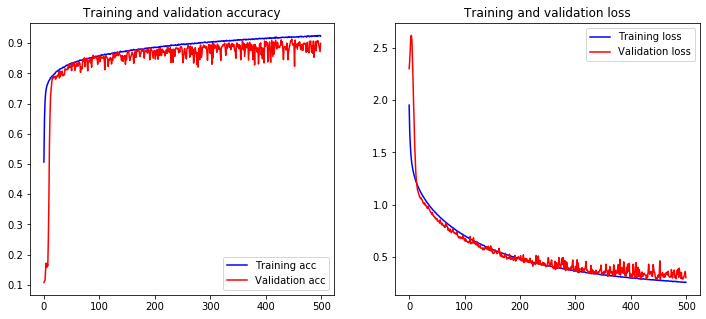

In [22]:
def plot_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


plot_loss(hist)

# Loading the best Model

In [23]:
model = load_model('model.h5')

# Evaluating the Model

In [24]:
train_loss, train_acc = model.evaluate_generator(train_generator, steps = len(train_generator))
print("Train Loss: ", train_loss)
print("Train Acc: ", train_acc)

Train Loss:  0.2912800681591034
Train Acc:  0.914098


In [25]:
validation_loss, validation_acc = model.evaluate_generator(validation_generator, steps = len(validation_generator))
print("Validation Loss: ", validation_loss)
print("Validation Acc: ", validation_acc)

Validation Loss:  0.281641885638237
Validation Acc:  0.914


# Getting the Test Data

In [26]:
test_data = pd.read_csv("fashion-mnist_test.csv")
test_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
test_data.shape

(10000, 785)

In [28]:
X_test = test_data.iloc[:, 1:]
y_test = test_data[['label']]

# Reshaping the Test Data

In [29]:
X_test = X_test.to_numpy().reshape(-1, 28, 28, 1)
y_test = y_test.to_numpy()

In [30]:
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X_test :  (10000, 28, 28, 1)
y_test :  (10000, 1)


# Rescaling the Test Input

In [31]:
X_test = X_test / 255

# Predicting the Labels of the Test Data

In [32]:
pred_probs = model.predict(X_test, batch_size = 1024)
print(pred_probs.shape)

(10000, 10)


In [33]:
pred_labels = pred_probs.argmax(axis=1)
print(pred_labels.shape)

(10000,)


# Getting the Test Accuracy

In [34]:
total_correct_labels = np.sum(np.squeeze(y_test) == pred_labels)

In [35]:
test_acc = total_correct_labels / y_test.shape[0]

In [36]:
print("Test Accuracy: {} %".format(test_acc * 100))

Test Accuracy: 91.82000000000001 %


# Creating the Output CSV File

In [37]:
imageid = np.arange(pred_labels.shape[0]) + 1
imageid

array([    1,     2,     3, ...,  9998,  9999, 10000])

In [38]:
df = pd.DataFrame({'ImageId': imageid, 'Label': pred_labels})
df.head()

,ImageId,Label
0,1,0
1,2,1
2,3,2
3,4,2
4,5,3


In [39]:
df.to_csv('test_output.csv', index = False)

**This model gave an accuracy of 91.82% on the Test Dataset.**